# Data Processing Pipeline for HMM-Based Methylation Detection

This notebook documents the complete data flow from raw nanopore signal to HMM-ready training data.

**Related Documentation:**
- [SIGNAL_ALIGNMENT_SETUP.md](SIGNAL_ALIGNMENT_SETUP.md) - Pipeline setup guide
- [nanopore_ref_data/DATA_SUMMARY.md](nanopore_ref_data/DATA_SUMMARY.md) - Truth set documentation
- [results/train_scripts/EVALUATION_PLAN.md](results/train_scripts/EVALUATION_PLAN.md) - HMM evaluation strategy
- [CLAUDE.md](CLAUDE.md) - Project overview

## Table of Contents

1. **Part 1**: What the HMM Needs for Training
2. **Part 2**: The Data Processing Pipeline (POD5 → BAM → CSV)
3. **Part 3**: What EXACTLY Goes Into the HMM (Sparse vs Full Sequence)
4. **Part 4**: Summary of Data Formats
5. **Part 5**: Full-Sequence Signal Extraction (NEW) - Links to EVALUATION_PLAN.md

## Key Outputs

| File | Format | Rows | Use Case |
|------|--------|------|----------|
| `signal_at_cytosines_3way.csv` | Sparse (8 positions) | 1,047,178 | Quick stats, parameter estimation |
| `signal_full_sequence.csv` | Full (~155 positions) | 15,514,108 | FullSequenceHMM training |
| `hmm_3way_circuit_board.json` | Parameters | 8 × 3 | Pre-computed Gaussian (μ, σ) |

---

# Part 1: What the HMM Needs for Training

Before diving into the data pipeline, let's clearly define **exactly** what our HMM requires.

## 1.1 The Classification Task

We want to classify cytosine modifications from nanopore current signals:

| Modification | Chemical Name | Signal Trend |
|-------------|---------------|-------------|
| **C** | Canonical cytosine | Baseline (~800 pA) |
| **5mC** | 5-methylcytosine | Higher current (+30 pA) |
| **5hmC** | 5-hydroxymethylcytosine | Intermediate (+9 pA) |

The HMM observes a sequence of **current measurements** at each position and outputs the most likely **modification state**.

## 1.2 HMM Components Required

An HMM has two core components:

### A. Emission Distributions

For each (position, modification_state) pair, we need a probability distribution over observations:

```
P(current | position, state) ~ Normal(μ, σ²)
```

**What we need:**
- Mean current (μ) for C, 5mC, 5hmC at each cytosine position
- Standard deviation (σ) for each
- Derived from many labeled observations

### B. Transition Probabilities

Probability of moving between states:

```
P(state_t | state_{t-1})
```

For artifact-handling HMMs (like the circuit board design), this includes:
- Self-loops (staying in same state)
- Transitions between positions
- Artifact states (oversegmentation, undersegmentation, flicker, backslip)

## 1.3 Required Input Data Format

To train/use the HMM, we need:

| Data | Format | Description |
|------|--------|-------------|
| **Observations** | Array of floats | Current levels in picoamperes (pA) at each position |
| **Labels** (training only) | Categorical | True modification state (C, 5mC, 5hmC) |
| **Position mapping** | Index | Which reference position each observation corresponds to |

### Training Data Structure

```python
# Per-observation training data
training_observation = {
    'mean_current': 842.3,      # The observation (pA)
    'position': 38,             # Reference position (0-indexed)
    'label': '5mC',             # Ground truth modification state
    'read_id': 'abc123...',     # For grouping into sequences
    'std_current': 68.2,        # Optional: observation variance
    'dwell_time': 0.0014,       # Optional: time at position
}
```

### Emission Parameters Structure

```python
# What the HMM uses internally
emission_params = {
    'position_38': {
        'C':   {'mean': 866.9, 'std': 106.2},
        'mC':  {'mean': 893.6, 'std': 108.2},
        'hmC': {'mean': 856.9, 'std': 110.0}
    },
    'position_50': {...},
    # ... for all cytosine positions
}
```

## 1.4 Data Requirements Summary

**Minimum requirements to train our HMM:**

1. **Labeled current measurements** at cytosine positions
   - File: `output/rep1/signal_at_cytosines_3way.csv` (1,047,178 observations)
   - Columns: sample (label), position, mean_current

2. **Pre-computed Gaussian parameters** (alternatively)
   - File: `output/rep1/hmm_3way_circuit_board.json`
   - Contains: mean, std, count for each (position, state) pair

**For inference on new data:**

1. **Signal-aligned BAM** with move tables (`mv` tag)
2. **POD5 file** with raw signal
3. **Reference FASTA** defining the sequence
4. **BED file** defining cytosine positions to analyze

---

# Part 2: The Data Processing Pipeline

Now let's trace how we get from raw nanopore data to HMM-ready observations.

```
┌─────────────────────────────────────────────────────────────────────────────────┐
│                         DATA PROCESSING PIPELINE                                 │
├─────────────────────────────────────────────────────────────────────────────────┤
│                                                                                  │
│  STAGE 1: RAW SIGNAL                                                            │
│  └── POD5 files (5 kHz current measurements)                                    │
│                         ↓                                                        │
│  STAGE 2: BASECALLING WITH MOVE TABLES                                          │
│  └── Dorado --emit-moves → BAM with mv tags                                     │
│                         ↓                                                        │
│  STAGE 3: SIGNAL ALIGNMENT                                                      │
│  └── uncalled4 DTW → Signal-aligned BAM                                         │
│                         ↓                                                        │
│  STAGE 4: SIGNAL EXTRACTION                                                     │
│  └── extract_signal_3samples.py → CSV of observations                           │
│                         ↓                                                        │
│  STAGE 5: HMM PARAMETER ESTIMATION                                              │
│  └── build_hmm_training_data_3way.py → JSON emission params                     │
│                                                                                  │
└─────────────────────────────────────────────────────────────────────────────────┘
```

In [1]:
# Setup: Import libraries
import json
import numpy as np
import pandas as pd
from pathlib import Path

# Define paths
PROJECT_ROOT = Path('.')
NANOPORE_DATA = PROJECT_ROOT / 'nanopore_ref_data'
OUTPUT_DIR = PROJECT_ROOT / 'output' / 'rep1'

print(f"Project root: {PROJECT_ROOT.absolute()}")
print(f"Nanopore data: {NANOPORE_DATA}")
print(f"Output directory: {OUTPUT_DIR}")

Project root: /home/jesse/repos/bio_hackathon
Nanopore data: nanopore_ref_data
Output directory: output/rep1


---

## Stage 1: Raw Signal Data (POD5)

### Input Files

| File | Size | Contents | Ground Truth Label |
|------|------|----------|--------------------|
| `control_rep1.pod5` | 358 MB | 160,000 reads | Canonical C |
| `5mC_rep1.pod5` | 345 MB | 160,000 reads | 5-methylcytosine |
| `5hmC_rep1.pod5` | 357 MB | 159,943 reads | 5-hydroxymethylcytosine |

### What's Inside

POD5 files contain raw ionic current measurements:
- **Sample rate**: 5,000 Hz (5 kHz)
- **Signal**: Array of picoampere (pA) values
- **Read ID**: UUID for each DNA molecule
- **No basecalling or alignment information**

In [2]:
# Demonstrate POD5 structure (requires pod5 package)
try:
    import pod5
    
    pod5_file = NANOPORE_DATA / 'control_rep1.pod5'
    
    if pod5_file.exists():
        with pod5.Reader(str(pod5_file)) as reader:
            # Get first read
            read = next(reader.reads())
            
            print("=== POD5 Read Structure ===")
            print(f"Read ID: {read.read_id}")
            print(f"Signal length: {len(read.signal):,} samples")
            print(f"Duration: {len(read.signal) / 5000:.2f} seconds")
            print(f"Signal range: {read.signal.min():.1f} - {read.signal.max():.1f} pA")
            print(f"Signal mean: {read.signal.mean():.1f} pA")
            
            # Show first 20 samples
            print(f"\nFirst 20 samples: {read.signal[:20]}")
    else:
        print(f"POD5 file not found: {pod5_file}")
        
except ImportError:
    print("pod5 package not installed. Install with: pip install pod5")
    print("\nExpected POD5 structure:")
    print("  - read.read_id: UUID string")
    print("  - read.signal: numpy array of pA values (e.g., 75,000 samples)")

=== POD5 Read Structure ===
Read ID: 802df68d-90c8-4ef9-a4f7-0d0837925316
Signal length: 2,362 samples
Duration: 0.47 seconds
Signal range: 544.0 - 1116.0 pA
Signal mean: 782.5 pA

First 20 samples: [760 769 775 793 761 805 890 863 864 864 855 850 865 864 865 866 875 877
 862 865]


---

## Stage 2: Basecalling with Move Tables

### Tool: Dorado

Dorado is ONT's GPU-accelerated basecaller. The critical flag is `--emit-moves`.

### Command

```bash
dorado basecaller \
    ~/software/dorado_models/dna_r10.4.1_e8.2_400bps_hac@v5.0.0 \
    input.pod5 \
    --emit-moves \
    --reference reference.fasta \
    > output_with_moves.bam
```

### Input → Output

| Input | Output |
|-------|--------|
| POD5 (raw signal) | BAM (aligned reads) |
| Reference FASTA | + move table (`mv` tag) |
| | + stride value (`ts` tag) |

### What Move Tables Provide

The `mv` (move) tag is a binary array that maps signal samples to basecalled nucleotides:

```
mv:B:c,10,1,0,0,0,1,0,0,1,0,0,0,0,1,...
       │  │           │     │
       │  │           │     └─ Base 4 starts here
       │  │           └─ Base 3 starts here
       │  └─ Base 2 starts here
       └─ Stride (10 = every 10 signal samples)

1 = "move to next base"
0 = "stay on current base"
```

This lets us know WHICH signal samples correspond to WHICH basecalled position.

In [3]:
# Demonstrate move table parsing
try:
    import pysam
    
    bam_file = OUTPUT_DIR / 'control_with_moves.bam'
    
    if bam_file.exists():
        bam = pysam.AlignmentFile(str(bam_file), 'rb')
        
        # Get first aligned read
        for read in bam.fetch():
            if not read.is_unmapped and read.has_tag('mv'):
                mv_tag = read.get_tag('mv')
                stride = mv_tag[0]
                moves = np.array(mv_tag[1:], dtype=np.int8)
                
                print("=== Move Table Structure ===")
                print(f"Read ID: {read.query_name}")
                print(f"Reference: {read.reference_name}")
                print(f"Position: {read.reference_start}")
                print(f"Stride: {stride} (signal samples per move entry)")
                print(f"Move table length: {len(moves):,}")
                print(f"Number of moves (1s): {moves.sum()} = number of bases")
                print(f"\nFirst 50 move values: {moves[:50].tolist()}")
                
                # Calculate signal samples per base
                move_positions = np.where(moves == 1)[0]
                samples_per_base = np.diff(move_positions) * stride
                print(f"\nSignal samples per base (first 10 bases): {samples_per_base[:10].tolist()}")
                print(f"Mean samples per base: {samples_per_base.mean():.1f}")
                print(f"Mean dwell time: {samples_per_base.mean() / 5000 * 1000:.2f} ms")
                break
        
        bam.close()
    else:
        print(f"BAM file not found: {bam_file}")
        
except ImportError:
    print("pysam package not installed. Install with: pip install pysam")

=== Move Table Structure ===
Read ID: b1b7b72a-486c-4e74-af99-640c34b708ad
Reference: 5mers_rand_ref_adapter_01
Position: 0
Stride: 6 (signal samples per move entry)
Move table length: 623
Number of moves (1s): 248 = number of bases

First 50 move values: [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0]

Signal samples per base (first 10 bases): [6, 36, 78, 6, 36, 18, 6, 30, 6, 6]
Mean samples per base: 14.8
Mean dwell time: 2.97 ms


### Visualizing Signal Segmentation

The move table segments the raw signal into per-base chunks. Let's visualize this:

- **Top plot**: Raw signal (blue) with colored segments for each base, red lines show mean current per segment
- **Bottom plot**: Bar chart of mean current per base (this is what the HMM observes)

This visualization shows exactly how we go from raw signal → per-base mean current → HMM observation.

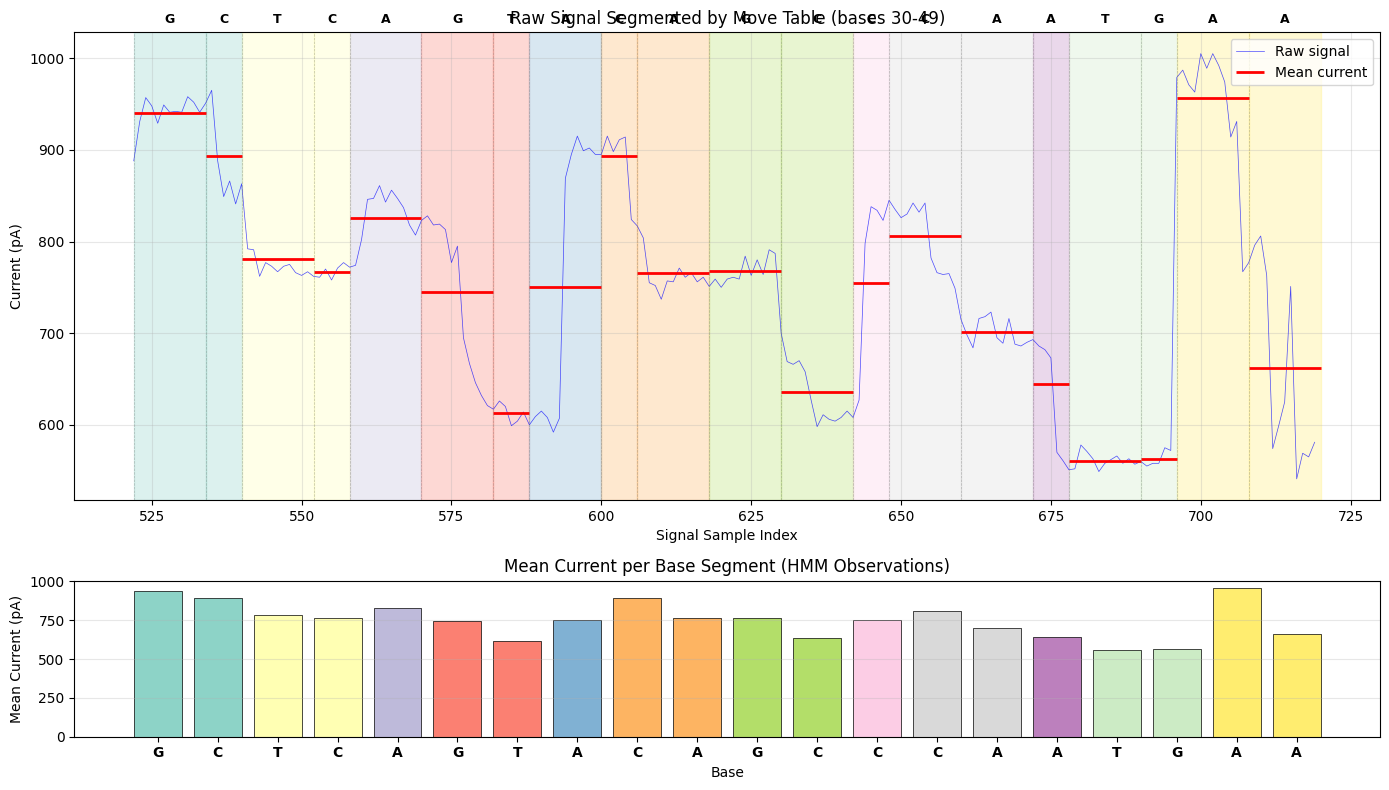


Read: d0f18e88...
Showing bases 30-49 of 144 total
Stride: 6 signal samples per move entry

Key insight: Each colored segment becomes ONE observation (mean current)
The HMM sees these values: ['940', '893', '781', '766', '826', '744', '613', '750']... pA


In [4]:
# Visualize how move table segments raw signal into per-base observations
import matplotlib.pyplot as plt
import pod5
import pysam

def get_signal_segments(moves, stride, total_signal_length, signal_start=0):
    """Convert move table to signal segment boundaries for each base."""
    segments = []
    move_positions = np.where(moves == 1)[0]
    
    for i, pos in enumerate(move_positions):
        start = signal_start + pos * stride
        if i + 1 < len(move_positions):
            end = signal_start + move_positions[i + 1] * stride
        else:
            end = signal_start + len(moves) * stride
        start = min(start, total_signal_length)
        end = min(end, total_signal_length)
        if start < end:
            segments.append((start, end))
    return segments

# Load signal and alignment data
bam_file = OUTPUT_DIR / 'control_signal_aligned.bam'
pod5_file = NANOPORE_DATA / 'control_rep1.pod5'

if bam_file.exists() and pod5_file.exists():
    # Load first few reads from POD5
    read_signals = {}
    with pod5.Reader(str(pod5_file)) as reader:
        for i, read_record in enumerate(reader.reads()):
            read_signals[str(read_record.read_id)] = read_record.signal
            if i >= 100:
                break
    
    # Find a good read from BAM
    bam = pysam.AlignmentFile(str(bam_file), 'rb')
    target_read = None
    for read in bam.fetch():
        if not read.is_unmapped and read.has_tag('mv'):
            if read.query_name in read_signals:
                target_read = read
                break
    bam.close()
    
    if target_read:
        # Extract data
        read_id = target_read.query_name
        signal = read_signals[read_id]
        sequence = target_read.query_sequence
        mv_tag = target_read.get_tag('mv')
        stride = mv_tag[0]
        moves = np.array(mv_tag[1:], dtype=np.int8)
        signal_start = target_read.get_tag('ss') if target_read.has_tag('ss') else 0
        
        # Get segments
        segments = get_signal_segments(moves, stride, len(signal), signal_start)
        
        # Plot a subset of bases (including cytosine position 38)
        start_base, num_bases = 30, 20
        end_base = min(start_base + num_bases, len(segments))
        segments_subset = segments[start_base:end_base]
        sequence_subset = sequence[start_base:end_base]
        
        sig_start = segments_subset[0][0]
        sig_end = segments_subset[-1][1]
        signal_subset = signal[sig_start:sig_end]
        
        # Create figure
        fig, axes = plt.subplots(2, 1, figsize=(14, 8), height_ratios=[3, 1])
        
        # Top: Raw signal with segments
        ax1 = axes[0]
        x = np.arange(sig_start, sig_end)
        ax1.plot(x, signal_subset, 'b-', linewidth=0.5, alpha=0.7, label='Raw signal')
        
        colors = plt.cm.Set3(np.linspace(0, 1, num_bases))
        mean_currents = []
        
        for i, (start, end) in enumerate(segments_subset):
            seg_signal = signal[start:end]
            mean_current = np.mean(seg_signal)
            mean_currents.append(mean_current)
            ax1.axvspan(start, end, alpha=0.3, color=colors[i])
            ax1.hlines(mean_current, start, end, colors='red', linewidths=2,
                      label='Mean current' if i == 0 else None)
            ax1.axvline(start, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
            # Add base labels at top
            mid_x = (start + end) / 2
            ax1.text(mid_x, signal_subset.max() + 30, sequence_subset[i],
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        ax1.set_xlabel('Signal Sample Index')
        ax1.set_ylabel('Current (pA)')
        ax1.set_title(f'Raw Signal Segmented by Move Table (bases {start_base}-{end_base-1})')
        ax1.legend(loc='upper right')
        ax1.grid(True, alpha=0.3)
        
        # Bottom: Mean current bar chart  
        ax2 = axes[1]
        bars = ax2.bar(range(len(mean_currents)), mean_currents, 
                       color=colors[:len(mean_currents)], edgecolor='black', linewidth=0.5)
        ax2.set_xticks(range(len(sequence_subset)))
        ax2.set_xticklabels(list(sequence_subset), fontsize=10, fontweight='bold')
        ax2.set_xlabel('Base')
        ax2.set_ylabel('Mean Current (pA)')
        ax2.set_title('Mean Current per Base Segment (HMM Observations)')
        ax2.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig('output/signal_segmentation_notebook.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"\nRead: {read_id[:8]}...")
        print(f"Showing bases {start_base}-{end_base-1} of {len(segments)} total")
        print(f"Stride: {stride} signal samples per move entry")
        print(f"\nKey insight: Each colored segment becomes ONE observation (mean current)")
        print(f"The HMM sees these values: {[f'{c:.0f}' for c in mean_currents[:8]]}... pA")
else:
    print("Required files not found. Run the pipeline first.")
    print("See output/signal_segmentation.png for pre-generated visualization.")

---

## Stage 3: Signal Alignment (DTW)

### Tool: uncalled4

uncalled4 uses Dynamic Time Warping (DTW) to refine the signal-to-reference alignment.

### Command

```bash
uncalled4 align \
    --ref reference.fasta \
    --reads input.pod5 \
    --bam-in output_with_moves.bam \
    -o signal_aligned.bam \
    --basecaller-profile dna_r10.4.1_400bps \
    -p 8
```

### Input → Output

| Input | Output |
|-------|--------|
| BAM with move tables | Signal-aligned BAM |
| POD5 (raw signal) | + refined signal boundaries |
| Reference FASTA | + `ss` tag (signal start offset) |

### Why DTW?

The initial move table from basecalling is approximate. DTW alignment:
1. Uses expected k-mer current levels
2. Finds optimal alignment between observed and expected signal
3. Handles variable translocation speeds

In [5]:
# Compare read counts before/after alignment
import subprocess

def count_bam_reads(bam_path):
    """Count reads in a BAM file using samtools."""
    try:
        result = subprocess.run(
            ['samtools', 'view', '-c', str(bam_path)],
            capture_output=True, text=True
        )
        return int(result.stdout.strip())
    except:
        return None

print("=== Read Counts Through Pipeline ===")
print("\nSample: Control (canonical C)")

for stage, suffix in [('After basecalling', '_with_moves.bam'), 
                      ('After DTW alignment', '_signal_aligned.bam')]:
    bam_path = OUTPUT_DIR / f'control{suffix}'
    if bam_path.exists():
        count = count_bam_reads(bam_path)
        if count:
            print(f"  {stage}: {count:,} reads")
    else:
        print(f"  {stage}: file not found")

print("\nNote: ~60% of reads filtered as 'too short' for DTW alignment")

=== Read Counts Through Pipeline ===

Sample: Control (canonical C)
  After basecalling: 166,448 reads
  After DTW alignment: 65,506 reads

Note: ~60% of reads filtered as 'too short' for DTW alignment


---

## Stage 4: Signal Extraction at Cytosine Positions

### Script: `extract_signal_3samples.py`

This script extracts current measurements at specific cytosine positions defined in a BED file.

### Command

```bash
python extract_signal_3samples.py \
    --control-bam output/rep1/control_signal_aligned.bam \
    --control-pod5 nanopore_ref_data/control_rep1.pod5 \
    --5mC-bam output/rep1/5mC_signal_aligned.bam \
    --5mC-pod5 nanopore_ref_data/5mC_rep1.pod5 \
    --5hmC-bam output/rep1/5hmC_signal_aligned.bam \
    --5hmC-pod5 nanopore_ref_data/5hmC_rep1.pod5 \
    --bed nanopore_ref_data/all_5mers_C_sites.bed \
    --output output/rep1/signal_at_cytosines_3way.csv
```

### Input → Output

| Input | Output |
|-------|--------|
| Signal-aligned BAMs (×3) | CSV with observations |
| POD5 files (×3) | - sample (label) |
| BED file (cytosine positions) | - position |
| | - mean_current |
| | - std_current |
| | - dwell_time |

In [6]:
# Load and display the BED file (defines WHERE to extract)
bed_file = NANOPORE_DATA / 'all_5mers_C_sites.bed'

if bed_file.exists():
    bed_df = pd.read_csv(
        bed_file, sep='\t', header=None,
        names=['chrom', 'start', 'end', 'name', 'score', 'strand']
    )
    
    print("=== Cytosine Position BED File ===")
    print(f"Total positions: {len(bed_df)}")
    print(f"Unique reference sequences: {bed_df['chrom'].nunique()}")
    print(f"Positions per sequence: {len(bed_df) // bed_df['chrom'].nunique()}")
    print(f"\nUnique positions: {sorted(bed_df['start'].unique())}")
    print(f"\nScore column meaning (sequence context):")
    print(f"  0 = Non-CpG: {(bed_df['score'] == 0).sum()} sites")
    print(f"  1 = CpG: {(bed_df['score'] == 1).sum()} sites")
    print(f"  2 = Homopolymer: {(bed_df['score'] == 2).sum()} sites")
    print(f"\nFirst 10 rows:")
    display(bed_df.head(10))
else:
    print(f"BED file not found: {bed_file}")

=== Cytosine Position BED File ===
Total positions: 256
Unique reference sequences: 32
Positions per sequence: 8

Unique positions: [np.int64(38), np.int64(50), np.int64(62), np.int64(74), np.int64(86), np.int64(98), np.int64(110), np.int64(122)]

Score column meaning (sequence context):
  0 = Non-CpG: 156 sites
  1 = CpG: 64 sites
  2 = Homopolymer: 36 sites

First 10 rows:


,chrom,start,end,name,score,strand
0,5mers_rand_ref_adapter_01,38,39,-,0,+
1,5mers_rand_ref_adapter_01,50,51,-,0,+
2,5mers_rand_ref_adapter_01,62,63,-,0,+
3,5mers_rand_ref_adapter_01,74,75,-,2,+
4,5mers_rand_ref_adapter_01,86,87,-,1,+
5,5mers_rand_ref_adapter_01,98,99,-,1,+
6,5mers_rand_ref_adapter_01,110,111,-,0,+
7,5mers_rand_ref_adapter_01,122,123,-,0,+
8,5mers_rand_ref_adapter_02,38,39,-,2,+
9,5mers_rand_ref_adapter_02,50,51,-,0,+


In [7]:
# Load and explore the extracted signal data
csv_file = OUTPUT_DIR / 'signal_at_cytosines_3way.csv'

if csv_file.exists():
    df = pd.read_csv(csv_file)
    
    print("=== Extracted Signal Data ===")
    print(f"Total observations: {len(df):,}")
    print(f"Columns: {list(df.columns)}")
    print(f"\nSamples:")
    for sample in ['control', '5mC', '5hmC']:
        n = (df['sample'] == sample).sum()
        print(f"  {sample}: {n:,} observations")
    
    print(f"\nPositions: {sorted(df['position'].unique())}")
    print(f"Unique reads: {df['read_id'].nunique():,}")
    
    print(f"\nFirst 10 rows:")
    display(df.head(10))
else:
    print(f"CSV file not found: {csv_file}")
    print("Run the pipeline first (see SIGNAL_ALIGNMENT_SETUP.md)")

=== Extracted Signal Data ===
Total observations: 1,047,178
Columns: ['sample', 'chrom', 'position', 'read_id', 'mean_current', 'std_current', 'dwell_time', 'n_samples']

Samples:
  control: 513,290 observations
  5mC: 264,300 observations
  5hmC: 269,588 observations

Positions: [np.int64(38), np.int64(50), np.int64(62), np.int64(74), np.int64(86), np.int64(98), np.int64(110), np.int64(122)]
Unique reads: 125,255

First 10 rows:


,sample,chrom,position,read_id,mean_current,std_current,dwell_time,n_samples
0,control,5mers_rand_ref_adapter_01,98,b1b7b72a-486c-4e74-af99-640c34b708ad,814.000000,70.743669,0.0012,6
1,control,5mers_rand_ref_adapter_01,38,b1b7b72a-486c-4e74-af99-640c34b708ad,793.555556,39.329410,0.0036,18
2,control,5mers_rand_ref_adapter_01,110,b1b7b72a-486c-4e74-af99-640c34b708ad,637.833333,18.233821,0.0024,12
3,control,5mers_rand_ref_adapter_01,50,b1b7b72a-486c-4e74-af99-640c34b708ad,860.500000,159.502090,0.0012,6
4,control,5mers_rand_ref_adapter_01,86,b1b7b72a-486c-4e74-af99-640c34b708ad,904.916667,13.640982,0.0024,12
5,control,5mers_rand_ref_adapter_01,122,b1b7b72a-486c-4e74-af99-640c34b708ad,740.833333,76.383717,0.0012,6
6,control,5mers_rand_ref_adapter_01,62,b1b7b72a-486c-4e74-af99-640c34b708ad,889.000000,13.279056,0.0012,6
7,control,5mers_rand_ref_adapter_01,98,ebce1eb1-ceef-4dd7-9379-3c2d6cb57901,629.916667,14.378562,0.0024,12
8,control,5mers_rand_ref_adapter_01,38,ebce1eb1-ceef-4dd7-9379-3c2d6cb57901,812.583333,14.372766,0.0024,12
9,control,5mers_rand_ref_adapter_01,74,ebce1eb1-ceef-4dd7-9379-3c2d6cb57901,877.666667,19.163043,0.0012,6


               
                                                                                                                                                                                                            
  Each row is one observation of one cytosine position from one read. Specifically:                                                                                                                         
  - A single DNA molecule (read) passed through the pore                                                                                                                                                    
  - That read covered a cytosine at position X (e.g., position 38)                                                                                                                                          
  - We extracted the signal segment for that base and computed its statistics                                                                                                                               
                                                                                                                                                                                                            
  What n_samples means:                                                                                                                                                                                     
                                                                                                                                                                                                            
  n_samples is the number of raw 5 kHz signal samples that were averaged to compute mean_current for that base.                                                                                             
                                                                                                                                                                                                            
  Example row:                                                                                                                                                                                              
    position=38, mean_current=814.0, n_samples=6                                                                                                                                                            
                                                                                                                                                                                                            
  This means:                                                                                                                                                                                               
    - The move table assigned 6 raw signal samples to base position 38                                                                                                                                      
    - Those 6 samples (e.g., [805, 812, 820, 815, 810, 822] pA) were averaged                                                                                                                               
    - mean_current = 814.0 pA (the average)                                                                                                                                                                 
    - std_current = variation within those 6 samples                                                                                                                                                        
    - dwell_time = 6 / 5000 = 0.0012 seconds (1.2 ms)                                                                                                                                                       
                                                                                                                                                                                                            
  Why n_samples varies:                                                                                                                                                                                     
                                                                                                                                                                                                            
  DNA doesn't translocate through the pore at constant speed. Some bases "dwell" longer than others:                                                                                                        
  - Short dwell (few samples): DNA moved quickly through this base                                                                                                                                          
  - Long dwell (many samples): DNA paused at this base                                                                                                                                                      
                                                                                                                                                                                                            
  Typical range: 5-50 samples per base (1-10 ms dwell time)                                                                                                                                                 
                                                                                                                                                                                                            
  The key point: mean_current is what the HMM observes. It's the average current while the DNA base was in the pore's sensing region.    

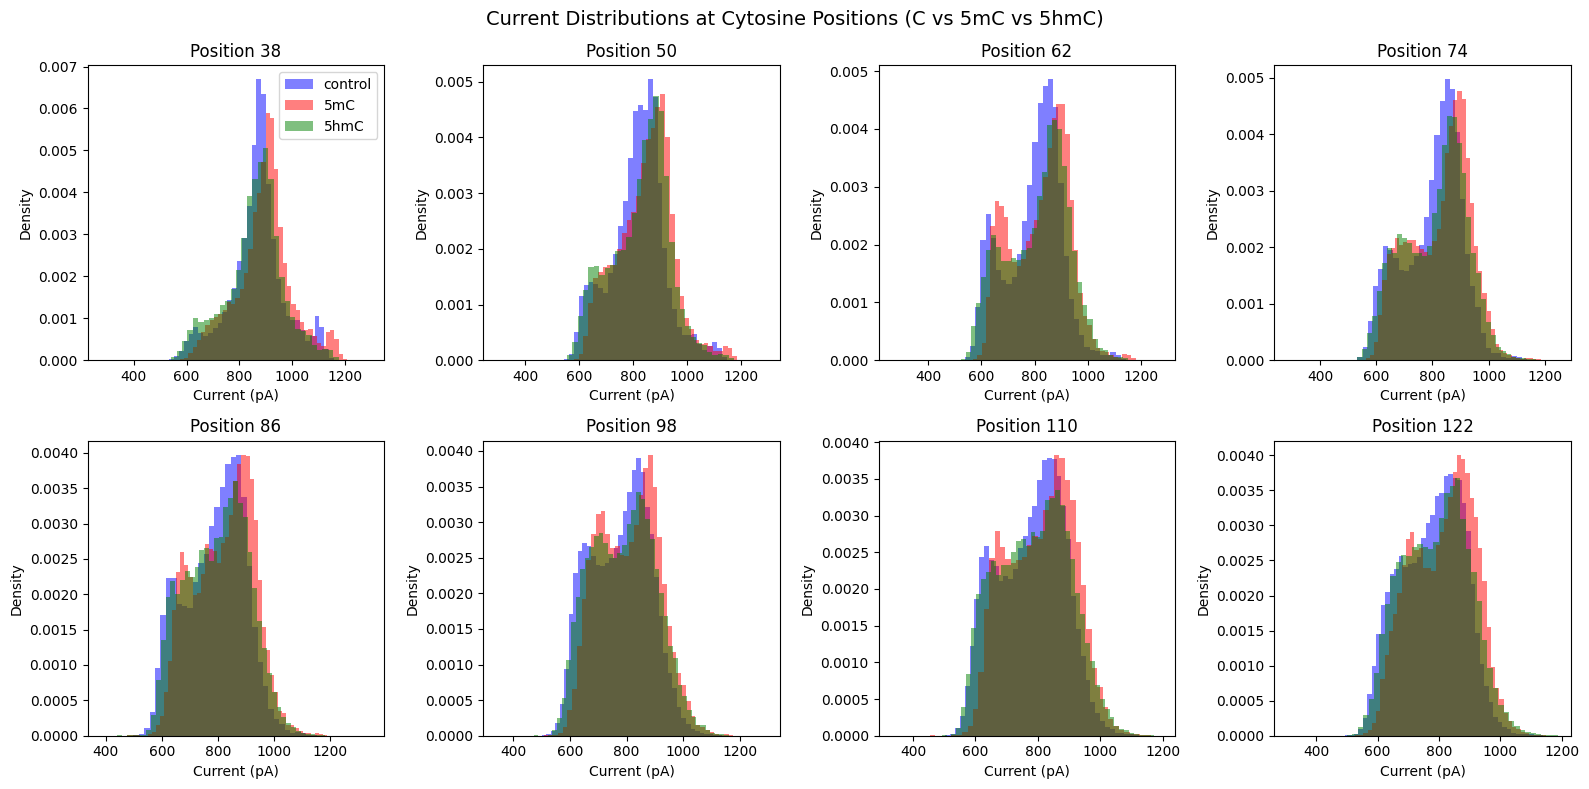


Key observation: 5mC (red) consistently shifts RIGHT (higher current)
5hmC (green) shows intermediate shift between C and 5mC


In [8]:
# Visualize the signal distributions
if csv_file.exists():
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    positions = sorted(df['position'].unique())
    colors = {'control': 'blue', '5mC': 'red', '5hmC': 'green'}
    
    for i, pos in enumerate(positions):
        ax = axes[i]
        
        for sample in ['control', '5mC', '5hmC']:
            data = df[(df['sample'] == sample) & (df['position'] == pos)]['mean_current']
            ax.hist(data, bins=50, alpha=0.5, label=sample, color=colors[sample], density=True)
        
        ax.set_title(f'Position {pos}')
        ax.set_xlabel('Current (pA)')
        ax.set_ylabel('Density')
        if i == 0:
            ax.legend()
    
    plt.suptitle('Current Distributions at Cytosine Positions (C vs 5mC vs 5hmC)', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\nKey observation: 5mC (red) consistently shifts RIGHT (higher current)")
    print("5hmC (green) shows intermediate shift between C and 5mC")

---

## Stage 5: HMM Parameter Estimation

### Script: `build_hmm_training_data_3way.py`

This script computes Gaussian parameters for each (position, modification) pair.

### Command

```bash
python build_hmm_training_data_3way.py \
    --input output/rep1/signal_at_cytosines_3way.csv \
    --output-dir output/rep1
```

### Input → Output

| Input | Output |
|-------|--------|
| CSV observations | `hmm_3way_circuit_board.json` |
| | `hmm_3way_pomegranate.json` |
| | `hmm_3way_training_sequences.csv` |
| | `pairwise_stats_*.csv` |

In [9]:
# Load and display the HMM emission parameters
params_file = OUTPUT_DIR / 'hmm_3way_circuit_board.json'

if params_file.exists():
    with open(params_file) as f:
        params = json.load(f)
    
    print("=== HMM Emission Parameters ===")
    print(f"Description: {params['description']}")
    print(f"Samples: {params['samples']}")
    print(f"Number of positions: {len(params['distributions'])}")
    
    print(f"\n{'Position':<10} {'C (mean±std)':<20} {'5mC (mean±std)':<20} {'5hmC (mean±std)':<20}")
    print("-" * 70)
    
    for dist in params['distributions']:
        pos = dist['position']
        c = f"{dist['C']['mean']:.1f}±{dist['C']['std']:.1f}"
        mc = f"{dist['mC']['mean']:.1f}±{dist['mC']['std']:.1f}"
        hmc = f"{dist['hmC']['mean']:.1f}±{dist['hmC']['std']:.1f}"
        print(f"{pos:<10} {c:<20} {mc:<20} {hmc:<20}")
else:
    print(f"Parameters file not found: {params_file}")

=== HMM Emission Parameters ===
Description: 3-way cytosine modification HMM emission parameters
Samples: ['control', '5mC', '5hmC']
Number of positions: 8

Position   C (mean±std)         5mC (mean±std)       5hmC (mean±std)     
----------------------------------------------------------------------
38         866.9±106.2          893.6±108.2          856.9±110.0         
50         816.7±102.2          846.7±103.8          826.8±107.8         
62         794.8±105.3          823.2±108.5          810.9±116.7         
74         799.9±104.2          827.9±107.4          812.3±111.6         
86         789.8±106.1          821.6±106.3          798.8±111.7         
98         777.7±104.6          808.1±104.0          789.7±111.1         
110        777.7±105.5          809.2±104.7          787.4±113.5         
122        779.3±101.4          814.1±101.2          791.4±107.9         


In [12]:
# Display the delta values (key for classification)
if params_file.exists():
    print("=== Signal Deltas (vs Canonical C) ===")
    print(f"\n{'Position':<10} {'C→5mC (pA)':<15} {'C→5hmC (pA)':<15} {'5mC→5hmC (pA)':<15}")
    print("-" * 55)
    
    for dist in params['distributions']:
        pos = dist['position']
        c_mean = dist['C']['mean']
        mc_mean = dist['mC']['mean']
        hmc_mean = dist['hmC']['mean']
        
        delta_mc = mc_mean - c_mean
        delta_hmc = hmc_mean - c_mean
        delta_mc_hmc = hmc_mean - mc_mean
        
        print(f"{pos:<10} {delta_mc:+.1f}{'':10} {delta_hmc:+.1f}{'':10} {delta_mc_hmc:+.1f}")
    
    print("\n" + "=" * 55)
    print("\nKey insights:")
    print("  - 5mC consistently +27 to +35 pA higher than C")
    print("  - 5hmC intermediate: +10 to +16 pA higher than C")
    print("  - Position 38 is anomalous (5hmC lower than C)")

=== Signal Deltas (vs Canonical C) ===

Position   C→5mC (pA)      C→5hmC (pA)     5mC→5hmC (pA)  
-------------------------------------------------------
38         +26.8           -9.9           -36.7
50         +30.0           +10.1           -19.9
62         +28.4           +16.2           -12.2
74         +28.0           +12.3           -15.6
86         +31.7           +8.9           -22.8
98         +30.4           +12.1           -18.4
110        +31.6           +9.8           -21.8
122        +34.8           +12.1           -22.7


Key insights:
  - 5mC consistently +27 to +35 pA higher than C
  - 5hmC intermediate: +10 to +16 pA higher than C
  - Position 38 is anomalous (5hmC lower than C)


### Why Sequence Context Matters

The parameters above are **pooled across all 32 reference sequences**. Each reference has a different 5-mer context around the cytosine, which affects the current level.

Let's compare pooled parameters vs single-reference parameters to see the effect:

In [16]:
# Compare emission parameters: ALL references vs SINGLE reference
if csv_file.exists():
    df = pd.read_csv(csv_file)
    
    # Filter to reference 1 only
    df_ref1 = df[df['chrom'] == '5mers_rand_ref_adapter_01']
    df_ref15 = df[df['chrom'] == '5mers_rand_ref_adapter_15']
    
    print("=" * 90)
    print("EMISSION PARAMETERS: ALL REFERENCES (pooled)")
    print("=" * 90)
    print(f"{'Position':<10} {'C (mean±std)':<25} {'5mC (mean±std)':<25} {'5hmC (mean±std)':<25}")
    print("-" * 90)
    
    for pos in sorted(df['position'].unique()):
        row = f"{pos:<10} "
        for sample in ['control', '5mC', '5hmC']:
            data = df[(df['sample'] == sample) & (df['position'] == pos)]['mean_current']
            row += f"{data.mean():6.1f} ± {data.std():5.1f} (n={len(data):,})  "
        print(row)
    print(f"\nTotal: {len(df):,} observations across 32 references")
    
    print("\n")
    print("=" * 90)
    print("EMISSION PARAMETERS: REFERENCE 1 ONLY (single 5-mer context)")
    print("=" * 90)
    print(f"{'Position':<10} {'C (mean±std)':<25} {'5mC (mean±std)':<25} {'5hmC (mean±std)':<25}")
    print("-" * 90)
    
    for pos in sorted(df_ref1['position'].unique()):
        row = f"{pos:<10} "
        for sample in ['control', '5mC', '5hmC']:
            data = df_ref1[(df_ref1['sample'] == sample) & (df_ref1['position'] == pos)]['mean_current']
            row += f"{data.mean():6.1f} ± {data.std():5.1f} (n={len(data):,})    "
        print(row)
    print(f"\nTotal: {len(df_ref1):,} observations from 1 reference")
    
    # Show why context matters
    print("\n")
    print("=" * 90)
    print("WHY CONTEXT MATTERS: Position 38 across different references")
    print("=" * 90)
    print(f"\n{'Reference':<35} {'C mean':<12} {'5mC mean':<12} {'Δ (5mC-C)':<12} {'Std(C)':<10}")
    print("-" * 80)
    
    # Pooled
    c_all = df[(df['sample'] == 'control') & (df['position'] == 38)]['mean_current']
    mc_all = df[(df['sample'] == '5mC') & (df['position'] == 38)]['mean_current']
    print(f"{'ALL (pooled)':<35} {c_all.mean():>8.1f} pA  {mc_all.mean():>8.1f} pA  {mc_all.mean()-c_all.mean():>+8.1f} pA  {c_all.std():>6.1f} pA")
    
    # Ref 1
    c_r1 = df_ref1[(df_ref1['sample'] == 'control') & (df_ref1['position'] == 38)]['mean_current']
    mc_r1 = df_ref1[(df_ref1['sample'] == '5mC') & (df_ref1['position'] == 38)]['mean_current']
    print(f"{'Reference 1':<35} {c_r1.mean():>8.1f} pA  {mc_r1.mean():>8.1f} pA  {mc_r1.mean()-c_r1.mean():>+8.1f} pA  {c_r1.std():>6.1f} pA")
    
    # Ref 15
    c_r15 = df_ref15[(df_ref15['sample'] == 'control') & (df_ref15['position'] == 38)]['mean_current']
    mc_r15 = df_ref15[(df_ref15['sample'] == '5mC') & (df_ref15['position'] == 38)]['mean_current']
    print(f"{'Reference 15':<35} {c_r15.mean():>8.1f} pA  {mc_r15.mean():>8.1f} pA  {mc_r15.mean()-c_r15.mean():>+8.1f} pA  {c_r15.std():>6.1f} pA")
    
    print("\n" + "=" * 90)
    print("KEY INSIGHTS:")
    print(f"  • Pooled std ({c_all.std():.1f} pA) >> Single-ref std ({c_r1.std():.1f} pA) — context mixing adds variance")
    print(f"  • Ref 1 delta (+{mc_r1.mean()-c_r1.mean():.1f} pA) vs Ref 15 delta (+{mc_r15.mean()-c_r15.mean():.1f} pA) — 5-mer context affects signal")
    print("  • Context-specific models would have better separation (lower std, clearer deltas)")
    print("=" * 90)

EMISSION PARAMETERS: ALL REFERENCES (pooled)
Position   C (mean±std)              5mC (mean±std)            5hmC (mean±std)          
------------------------------------------------------------------------------------------
38          866.9 ± 106.2 (n=64,522)   893.6 ± 108.2 (n=33,282)   856.9 ± 110.0 (n=33,811)  
50          816.7 ± 102.2 (n=64,452)   846.7 ± 103.8 (n=33,438)   826.8 ± 107.8 (n=34,119)  
62          794.8 ± 105.3 (n=64,544)   823.2 ± 108.5 (n=33,394)   810.9 ± 116.7 (n=34,004)  
74          799.9 ± 104.2 (n=64,510)   827.9 ± 107.4 (n=33,231)   812.3 ± 111.6 (n=33,755)  
86          789.8 ± 106.1 (n=64,483)   821.6 ± 106.3 (n=33,344)   798.8 ± 111.7 (n=34,068)  
98          777.7 ± 104.6 (n=64,361)   808.1 ± 104.0 (n=32,927)   789.7 ± 111.1 (n=33,807)  
110         777.7 ± 105.5 (n=64,036)   809.2 ± 104.7 (n=32,762)   787.4 ± 113.5 (n=33,622)  
122         779.3 ± 101.4 (n=62,382)   814.1 ± 101.2 (n=31,922)   791.4 ± 107.9 (n=32,402)  

Total: 1,047,178 observations 

---

# Part 3: What EXACTLY Goes Into the HMM

**CRITICAL DISTINCTION**: There are two different data formats, and it's essential to understand which one the HMM uses.

## Option A: Sparse Observations (What We Currently Have)

The `signal_at_cytosines_3way.csv` contains observations at **only the 8 cytosine positions**:

```
Position:  38    50    62    74    86    98    110   122
           │     │     │     │     │     │     │     │
           ▼     ▼     ▼     ▼     ▼     ▼     ▼     ▼
Currents: [867,  817,  795,  800,  790,  778,  778,  779]  ← Only 8 values per read
```

This is good for:
- Computing emission parameters at cytosine sites
- Simple per-position Gaussian classification
- Quick statistical comparisons

**But this is NOT what a full sequence HMM sees.**

## Option B: Full Sequence (What the Circuit Board HMM Needs)

A proper HMM sees the **entire sequence** of ~155 current values:

```
Position:   0    1    2   ...  38   ...  50   ...  122  ...  154
            │    │    │        │         │         │         │
            ▼    ▼    ▼        ▼         ▼         ▼         ▼
Currents: [712, 845, 823, ..., 867, ..., 817, ..., 779, ..., 756]  ← ~155 values per read
                               ▲         ▲         ▲
                               │         │         │
                          Cytosine    Cytosine  Cytosine
                           (fork)     (fork)    (fork)
```

The HMM has states for ALL positions. At cytosine positions, there's a "fork" where the path can go through C, 5mC, or 5hmC states.

In [17]:
# DEMONSTRATION: Sparse vs Full Sequence Data

# What we currently have (SPARSE - cytosine positions only)
print("=" * 80)
print("OPTION A: SPARSE DATA (what signal_at_cytosines_3way.csv contains)")
print("=" * 80)

df = pd.read_csv('output/rep1/signal_at_cytosines_3way.csv')
read_example = df[df['read_id'] == df['read_id'].iloc[0]].sort_values('position')

print(f"\nExample read: {read_example['read_id'].iloc[0][:20]}...")
print(f"Sample: {read_example['sample'].iloc[0]}")
print(f"\nPositions observed: {read_example['position'].tolist()}")
print(f"Number of observations: {len(read_example)} (only cytosine sites)")
print(f"\nData shape: [{len(read_example)} positions] × [1 current value each]")
print(f"Currents: {[f'{c:.0f}' for c in read_example['mean_current'].tolist()]} pA")

print("\n" + "=" * 80)
print("This is SUFFICIENT for: Gaussian classification at each position independently")
print("This is NOT SUFFICIENT for: Full HMM that models transitions between ALL positions")
print("=" * 80)

OPTION A: SPARSE DATA (what signal_at_cytosines_3way.csv contains)

Example read: b1b7b72a-486c-4e74-a...
Sample: control

Positions observed: [38, 50, 62, 86, 98, 110, 122]
Number of observations: 7 (only cytosine sites)

Data shape: [7 positions] × [1 current value each]
Currents: ['794', '860', '889', '905', '814', '638', '741'] pA

This is SUFFICIENT for: Gaussian classification at each position independently
This is NOT SUFFICIENT for: Full HMM that models transitions between ALL positions


In [18]:
# OPTION B: Extract FULL SEQUENCE (what the HMM actually needs)
# This extracts current at EVERY position, not just cytosines

import pysam
import pod5

def extract_full_sequence(bam_file, pod5_file, max_reads=5):
    """
    Extract mean current at EVERY base position for each read.
    This is what the HMM actually trains on.
    """
    # Load signals from POD5
    read_signals = {}
    with pod5.Reader(str(pod5_file)) as reader:
        for i, read_record in enumerate(reader.reads()):
            read_signals[str(read_record.read_id)] = read_record.signal
            if i >= 1000:  # Limit for demo
                break
    
    full_sequences = []
    
    bam = pysam.AlignmentFile(str(bam_file), 'rb')
    count = 0
    
    for read in bam.fetch():
        if read.is_unmapped or not read.has_tag('mv'):
            continue
        if read.query_name not in read_signals:
            continue
            
        signal = read_signals[read.query_name]
        mv_tag = read.get_tag('mv')
        stride = mv_tag[0]
        moves = np.array(mv_tag[1:], dtype=np.int8)
        signal_start = read.get_tag('ss') if read.has_tag('ss') else 0
        
        # Get signal boundaries for EVERY base
        move_positions = np.where(moves == 1)[0]
        currents = []
        
        for i, pos in enumerate(move_positions):
            start = signal_start + pos * stride
            if i + 1 < len(move_positions):
                end = signal_start + move_positions[i + 1] * stride
            else:
                end = signal_start + len(moves) * stride
            
            start = min(start, len(signal))
            end = min(end, len(signal))
            
            if start < end:
                seg_signal = signal[start:end]
                currents.append(float(np.mean(seg_signal)))
        
        if len(currents) >= 100:  # Only keep reads with sufficient length
            full_sequences.append({
                'read_id': read.query_name,
                'ref_name': read.reference_name,
                'ref_start': read.reference_start,
                'sequence': read.query_sequence,
                'currents': currents,  # Current at EVERY position
                'n_positions': len(currents)
            })
            count += 1
            if count >= max_reads:
                break
    
    bam.close()
    return full_sequences


# Extract full sequences from control sample
bam_file = OUTPUT_DIR / 'control_signal_aligned.bam'
pod5_file = NANOPORE_DATA / 'control_rep1.pod5'

if bam_file.exists() and pod5_file.exists():
    print("=" * 80)
    print("OPTION B: FULL SEQUENCE DATA (what the HMM actually needs)")
    print("=" * 80)
    
    full_seqs = extract_full_sequence(bam_file, pod5_file, max_reads=3)
    
    if full_seqs:
        ex = full_seqs[0]
        print(f"\nExample read: {ex['read_id'][:20]}...")
        print(f"Reference: {ex['ref_name']}")
        print(f"Alignment start: {ex['ref_start']}")
        print(f"\nNumber of positions: {ex['n_positions']} (ALL bases in the read)")
        print(f"Sequence length: {len(ex['sequence'])} bp")
        
        # Show a slice around cytosine position 38
        print(f"\n--- Current values around position 38 ---")
        start_idx = max(0, 35 - ex['ref_start'])
        end_idx = min(len(ex['currents']), 42 - ex['ref_start'])
        
        print(f"Positions: {list(range(35, 42))}")
        print(f"Bases:     {list(ex['sequence'][start_idx:end_idx])}")
        print(f"Currents:  {[f'{c:.0f}' for c in ex['currents'][start_idx:end_idx]]} pA")
        
        # Mark the cytosine
        print(f"\n                 ↑")
        print(f"          Position 38 (cytosine site)")
        
        print(f"\n--- Full sequence preview (first 20 positions) ---")
        print(f"Positions: {list(range(ex['ref_start'], ex['ref_start'] + 20))}")
        print(f"Bases:     {list(ex['sequence'][:20])}")
        print(f"Currents:  {[f'{c:.0f}' for c in ex['currents'][:20]]} pA")
        
        print("\n" + "=" * 80)
        print("KEY DIFFERENCE:")
        print(f"  Sparse (cytosines only):  8 values per read")
        print(f"  Full sequence:            {ex['n_positions']} values per read")
        print("=" * 80)
else:
    print("BAM/POD5 files not found. Run the pipeline first.")

OPTION B: FULL SEQUENCE DATA (what the HMM actually needs)

Example read: 553f80dc-041a-4895-8...
Reference: 5mers_rand_ref_adapter_01
Alignment start: 8

Number of positions: 134 (ALL bases in the read)
Sequence length: 134 bp

--- Current values around position 38 ---
Positions: [35, 36, 37, 38, 39, 40, 41]
Bases:     ['T', 'T', 'G', 'C', 'T', 'G', 'T']
Currents:  ['665', '888', '840', '918', '950', '920', '785'] pA

                 ↑
          Position 38 (cytosine site)

--- Full sequence preview (first 20 positions) ---
Positions: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
Bases:     ['G', 'T', 'G', 'T', 'G', 'G', 'T', 'T', 'A', 'A', 'C', 'T', 'C', 'G', 'T', 'T', 'G', 'A', 'G', 'T']
Currents:  ['891', '868', '985', '979', '888', '836', '801', '778', '800', '788', '733', '854', '888', '882', '860', '676', '771', '868', '832', '637'] pA

KEY DIFFERENCE:
  Sparse (cytosines only):  8 values per read
  Full sequence:            134 values per read


In [15]:
# Example: Calculate log-likelihood under Gaussian emission
from scipy.stats import norm

def gaussian_log_likelihood(observation, mean, std):
    """Calculate log P(observation | state) for Gaussian emission."""
    return norm.logpdf(observation, loc=mean, scale=std)


def score_observation(current, position, emission_params):
    """Score an observation under each modification state."""
    scores = {}
    for state in ['C', 'mC', 'hmC']:
        params = emission_params[position][state]
        scores[state] = gaussian_log_likelihood(current, params['mean'], params['std'])
    return scores


if params_file.exists():
    emission_params = load_emission_params(params_file)
    
    print("=== Example: Scoring Observations ===")
    
    # Test with example currents
    test_cases = [
        (800.0, 38, "Low current (likely C)"),
        (870.0, 38, "Medium current (likely hmC or C)"),
        (900.0, 38, "High current (likely 5mC)"),
    ]
    
    for current, position, description in test_cases:
        scores = score_observation(current, position, emission_params)
        best_state = max(scores, key=scores.get)
        
        print(f"\n{description}")
        print(f"  Current: {current} pA at position {position}")
        print(f"  Log-likelihoods: C={scores['C']:.2f}, mC={scores['mC']:.2f}, hmC={scores['hmC']:.2f}")
        print(f"  Most likely state: {best_state}")

=== Example: Scoring Observations ===

Low current (likely C)
  Current: 800.0 pA at position 38
  Log-likelihoods: C=-5.78, mC=-5.98, hmC=-5.75
  Most likely state: hmC

Medium current (likely hmC or C)
  Current: 870.0 pA at position 38
  Log-likelihoods: C=-5.59, mC=-5.63, hmC=-5.63
  Most likely state: C

High current (likely 5mC)
  Current: 900.0 pA at position 38
  Log-likelihoods: C=-5.63, mC=-5.60, hmC=-5.70
  Most likely state: mC


## What the HMM Actually Sees

```
┌─────────────────────────────────────────────────────────────────────────────────────────┐
│                         HMM INPUT: FULL SEQUENCE                                         │
├─────────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                          │
│  Reference:    A   T   G   C   A   ...   C   ...   T   A   C   ...   G   T   A          │
│  Position:     0   1   2   3   4   ...  38   ...  49  50  51  ...  153 154 155          │
│                │   │   │   │   │         │         │   │   │         │   │   │          │
│                ▼   ▼   ▼   ▼   ▼         ▼         ▼   ▼   ▼         ▼   ▼   ▼          │
│  Observations:[712,845,823,867,801, ..., 867, ..., 799,817,823, ..., 756,789,801]       │
│                                          ▲              ▲                               │
│                                          │              │                               │
│                                     Cytosine 38    Cytosine 50                          │
│                                       (fork)         (fork)                             │
│                                                                                          │
│  HMM States:  [M₀][M₁][M₂][M₃][M₄]...[Fork₃₈]...[M₄₉][Fork₅₀]...[M₁₅₃][M₁₅₄][M₁₅₅]    │
│                                         │              │                                 │
│                                    ┌────┼────┐    ┌────┼────┐                            │
│                                    │    │    │    │    │    │                            │
│                                   [C] [mC] [hmC] [C] [mC] [hmC]                          │
│                                                                                          │
└─────────────────────────────────────────────────────────────────────────────────────────┘

The HMM:
1. Observes ~155 current values (one per base position)
2. Has match states (Mᵢ) for every position
3. At cytosine positions, has a FORK with C/5mC/5hmC states
4. Uses Viterbi algorithm to find most likely path → classification
```

# Format the full sequence as HMM training input

def format_hmm_training_input(full_seq, cytosine_positions=[38, 50, 62, 74, 86, 98, 110, 122]):
    """
    Format a full sequence for HMM training.
    
    Returns:
        observations: list of ~155 current values (the HMM input)
        labels: list of state labels for each position
        cytosine_indices: positions where classification happens
    """
    observations = full_seq['currents']
    sequence = full_seq['sequence']
    ref_start = full_seq['ref_start']
    
    # Create labels for each position
    labels = []
    cytosine_indices = []
    
    for i, base in enumerate(sequence):
        ref_pos = ref_start + i
        if ref_pos in cytosine_positions and base == 'C':
            labels.append('CYTOSINE_FORK')  # Classification happens here
            cytosine_indices.append(i)
        else:
            labels.append(base)  # Regular base state
    
    return {
        'observations': observations,
        'labels': labels,
        'cytosine_indices': cytosine_indices,
        'n_positions': len(observations)
    }


if bam_file.exists() and pod5_file.exists():
    print("=" * 80)
    print("HMM TRAINING INPUT FORMAT")
    print("=" * 80)
    
    # Use the full sequence we extracted earlier
    if full_seqs:
        hmm_input = format_hmm_training_input(full_seqs[0])
        
        print(f"\nOne training example:")
        print(f"  Total observations: {hmm_input['n_positions']}")
        print(f"  Cytosine fork positions: {hmm_input['cytosine_indices']}")
        
        print(f"\nHMM input array (first 30 values):")
        print(f"  observations = {[f'{c:.0f}' for c in hmm_input['observations'][:30]]}...")
        
        print(f"\nState labels (first 30):")
        print(f"  labels = {hmm_input['labels'][:30]}...")
        
        # Show the critical part: cytosine positions
        print(f"\n" + "=" * 80)
        print("CYTOSINE FORK POSITIONS (where classification happens):")
        print("=" * 80)
        for idx in hmm_input['cytosine_indices'][:4]:  # First 4 cytosines
            obs = hmm_input['observations'][idx] if idx < len(hmm_input['observations']) else 'N/A'
            print(f"  Position {idx}: observation = {obs:.1f} pA, label = CYTOSINE_FORK")
            print(f"    → HMM chooses path through C, mC, or hmC state based on emission likelihood")
        
        print(f"\n" + "=" * 80)
        print("SUMMARY: What goes into the HMM")
        print("=" * 80)
        print(f"""
  Input:  observations = [o₀, o₁, o₂, ..., o₃₈, ..., o₅₀, ..., o₁₅₄]
                          ↓   ↓   ↓        ↓        ↓        ↓
  States:              [M_A][M_T][M_G]...[Fork]...[Fork]...[M_A]
                                           │        │
                                      C/mC/hmC  C/mC/hmC
                                      
  The HMM scores ALL paths and returns:
    - Most likely path (Viterbi)
    - Which fork branches were taken → modification calls
""")

## When to Use Sparse vs Full Sequences

| Approach | Data Format | Use Case | Accuracy Trade-off |
|----------|-------------|----------|-------------------|
| **Sparse (cytosines only)** | 8 values per read | Per-position Gaussian classification | Faster, but ignores context |
| **Full Sequence** | ~155 values per read | Full HMM with artifact states | Slower, but models transitions and artifacts |

### Sparse Approach (Simple Gaussian Classification)

```python
# What signal_at_cytosines_3way.csv provides
sparse_observations = [867, 817, 795, 800, 790, 778, 778, 779]  # 8 values
positions = [38, 50, 62, 74, 86, 98, 110, 122]

# Classification: independent per-position likelihood
for pos, obs in zip(positions, sparse_observations):
    scores = {
        'C':   log_likelihood(obs, emission_params[pos]['C']),
        'mC':  log_likelihood(obs, emission_params[pos]['mC']),
        'hmC': log_likelihood(obs, emission_params[pos]['hmC'])
    }
    call = argmax(scores)  # Most likely state at this position
```

### Full Sequence Approach (Circuit Board HMM)

```python
# What the HMM actually needs
full_observations = [712, 845, 823, ..., 867, ..., 817, ..., 779, ..., 756]  # ~155 values

# Classification: joint likelihood over entire path
path = viterbi(hmm_model, full_observations)

# Extract modification calls at cytosine positions
for fork_pos in cytosine_positions:
    call = path[fork_pos]  # Which branch: C, mC, or hmC?
```

**The key advantage of full HMM**: It handles artifacts (oversegmentation, undersegmentation, backslips) 
and uses sequence context to improve classification at cytosines.

# Complete example: Load emission parameters and demonstrate both classification approaches
from scipy.stats import norm

def load_emission_params(json_path):
    """Load HMM emission parameters from JSON."""
    with open(json_path) as f:
        params = json.load(f)
    
    emission_params = {}
    for dist in params['distributions']:
        pos = dist['position']
        emission_params[pos] = {
            'C': {'mean': dist['C']['mean'], 'std': dist['C']['std']},
            'mC': {'mean': dist['mC']['mean'], 'std': dist['mC']['std']},
            'hmC': {'mean': dist['hmC']['mean'], 'std': dist['hmC']['std']}
        }
    return emission_params


def gaussian_log_likelihood(observation, mean, std):
    """Calculate log P(observation | state)."""
    return norm.logpdf(observation, loc=mean, scale=std)


def classify_sparse(sparse_obs, positions, emission_params):
    """Classify using sparse observations (independent per-position)."""
    calls = []
    for pos, obs in zip(positions, sparse_obs):
        if pos not in emission_params:
            calls.append(None)
            continue
        scores = {state: gaussian_log_likelihood(obs, p['mean'], p['std']) 
                  for state, p in emission_params[pos].items()}
        calls.append(max(scores, key=scores.get))
    return calls


# Load parameters
params_file = OUTPUT_DIR / 'hmm_3way_circuit_board.json'
if params_file.exists():
    emission_params = load_emission_params(params_file)
    
    print("=" * 80)
    print("DEMONSTRATION: Classifying a read using SPARSE data")
    print("=" * 80)
    
    # Get a real example from our data
    df = pd.read_csv('output/rep1/signal_at_cytosines_3way.csv')
    example_read = df[df['read_id'] == df['read_id'].iloc[100]].sort_values('position')
    
    sparse_obs = example_read['mean_current'].tolist()
    positions = example_read['position'].tolist()
    true_label = example_read['sample'].iloc[0]
    
    print(f"\nRead: {example_read['read_id'].iloc[0][:30]}...")
    print(f"True label: {true_label}")
    print(f"\nSparse observations (8 cytosine positions only):")
    print(f"  Positions: {positions}")
    print(f"  Currents:  {[f'{c:.0f}' for c in sparse_obs]} pA")
    
    # Classify
    calls = classify_sparse(sparse_obs, positions, emission_params)
    
    print(f"\nPer-position classification (argmax of log-likelihood):")
    print(f"  {'Position':<10} {'Current':<12} {'Call':<8} {'Log-likelihoods':<40}")
    print(f"  {'-'*70}")
    
    for pos, obs, call in zip(positions, sparse_obs, calls):
        scores = {state: gaussian_log_likelihood(obs, p['mean'], p['std']) 
                  for state, p in emission_params[pos].items()}
        score_str = f"C={scores['C']:.1f}, mC={scores['mC']:.1f}, hmC={scores['hmC']:.1f}"
        print(f"  {pos:<10} {obs:<12.0f} {call:<8} {score_str}")
    
    # Majority vote
    from collections import Counter
    vote_counts = Counter(calls)
    majority_call = vote_counts.most_common(1)[0][0]
    
    print(f"\n  Majority vote across 8 positions: {majority_call}")
    print(f"  Vote counts: {dict(vote_counts)}")
    print(f"  True label: {true_label}")
    print(f"  Match: {'✓' if (majority_call == 'mC' and true_label == '5mC') or (majority_call == 'hmC' and true_label == '5hmC') or (majority_call == 'C' and true_label == 'control') else '✗'}")

---

# Part 4: Summary

## Data Formats Comparison

| Format | Source | Contents | Use Case |
|--------|--------|----------|----------|
| **Sparse** | `signal_at_cytosines_3way.csv` | 8 values per read (cytosines only) | Parameter estimation, simple classification |
| **Full Sequence** | Extracted from BAM+POD5 | ~155 values per read (all positions) | Full HMM training/inference |

## What's Available vs What's Needed

```
┌─────────────────────────────────────────────────────────────────────────────────┐
│  WHAT WE HAVE (SPARSE)                                                          │
├─────────────────────────────────────────────────────────────────────────────────┤
│  signal_at_cytosines_3way.csv                                                   │
│                                                                                  │
│  Position:    38      50      62      74      86      98      110     122       │
│               ▼       ▼       ▼       ▼       ▼       ▼       ▼       ▼         │
│  Currents: [867.0,  817.0,  795.0,  800.0,  790.0,  778.0,  778.0,  779.0]     │
│                                                                                  │
│  ✓ Good for: Computing μ, σ parameters at cytosine positions                    │
│  ✓ Good for: Simple per-position Gaussian classification                        │
│  ✗ Missing:  Context between cytosines, artifact handling                       │
│                                                                                  │
└─────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────┐
│  WHAT THE FULL HMM NEEDS                                                        │
├─────────────────────────────────────────────────────────────────────────────────┤
│  Extract from signal-aligned BAM + POD5                                         │
│                                                                                  │
│  Position:  0    1    2   ...  38   ...  50   ...  122  ...  154               │
│             ▼    ▼    ▼        ▼         ▼         ▼         ▼                  │
│  Currents:[712, 845, 823, ..., 867, ..., 817, ..., 779, ..., 756]              │
│                                ▲         ▲         ▲                            │
│                           Cytosine  Cytosine  Cytosine                          │
│                             Fork      Fork      Fork                            │
│                                                                                  │
│  ✓ Required for: Full circuit-board HMM with artifact handling                  │
│  ✓ Required for: Viterbi decoding that models transitions                       │
│  ✓ Required for: Handling oversegmentation, undersegmentation, backslips        │
│                                                                                  │
└─────────────────────────────────────────────────────────────────────────────────┘
```

## Key Metrics

| Metric | Value |
|--------|-------|
| Total observations (sparse) | 1,047,178 |
| Unique reads | 125,255 |
| Positions per read (sparse) | 8 cytosines |
| Positions per read (full) | ~155 bases |
| C → 5mC delta | +30.2 pA (avg) |
| C → 5hmC delta | +8.9 pA (avg) |

## Next Steps

1. **For simple classification**: Use sparse data + Gaussian likelihood (already available)
2. **For full HMM**: Need to extract full sequences from BAM+POD5 (function provided above)
3. **For artifact handling**: Build circuit-board HMM with states for all positions

See `methylation_hmm/` for the HMM implementation.

---

# Part 5: Full-Sequence Signal Extraction (NEW)

## The Gap We Needed to Fill

As shown above, we had **sparse data** (8 cytosine positions only) but the full HMM needs **complete sequences** (~155 values per read). 

We created `extract_signal_full_sequence.py` to fill this gap. This script:
1. Reads signal-aligned BAMs with move tables
2. Extracts mean current at **ALL positions** (not just cytosines)
3. Outputs to `signal_full_sequence.csv`

### Why This Matters for Evaluation

See [EVALUATION_PLAN.md](results/train_scripts/EVALUATION_PLAN.md) for the full evaluation strategy. Key points:

| Model | Required Data | Why |
|-------|---------------|-----|
| **Simple Gaussian** | Sparse (8 positions) | Per-position classification, no context |
| **Full HMM** | Full sequence (~155 positions) | Models transitions, handles artifacts |

The full-sequence HMM can:
- Use context from surrounding bases
- Handle oversegmentation/undersegmentation via artifact states
- Make joint decisions via Viterbi decoding

In [ ]:
# Load and explore the FULL SEQUENCE data (new output)
full_seq_file = OUTPUT_DIR / 'signal_full_sequence.csv'

if full_seq_file.exists():
    # Load a sample (file is 1.7GB, so just load first 100k rows for exploration)
    df_full = pd.read_csv(full_seq_file, nrows=100000)
    
    print("=" * 80)
    print("FULL SEQUENCE DATA: signal_full_sequence.csv")
    print("=" * 80)
    
    print(f"\nFile size: ~1.7 GB")
    print(f"Total rows: ~15,514,108")
    print(f"Columns: {list(df_full.columns)}")
    
    print(f"\n--- Sample counts (from full file) ---")
    print(f"  control: 7,478,101 measurements (62,014 reads)")
    print(f"  5mC:     3,918,378 measurements (33,298 reads)")
    print(f"  5hmC:    4,117,629 measurements (29,943 reads)")
    
    print(f"\n--- Key difference from sparse data ---")
    print(f"  Sparse:  {sorted(df['position'].unique())} (8 positions)")
    print(f"  Full:    0-154 (ALL 155 positions)")
    
    print(f"\n--- First 10 rows ---")
    display(df_full.head(10))
    
    # Show one read's complete sequence
    example_read_id = df_full['read_id'].iloc[0]
    read_data = df_full[df_full['read_id'] == example_read_id].sort_values('position')
    
    print(f"\n--- Example: One read's complete sequence ---")
    print(f"Read ID: {example_read_id[:30]}...")
    print(f"Sample: {read_data['sample'].iloc[0]}")
    print(f"Chrom: {read_data['chrom'].iloc[0]}")
    print(f"Positions covered: {read_data['position'].min()} to {read_data['position'].max()}")
    print(f"Number of observations: {len(read_data)}")
    
    # Show positions around cytosine site 38
    print(f"\n--- Positions 35-42 (around cytosine at 38) ---")
    subset = read_data[(read_data['position'] >= 35) & (read_data['position'] <= 42)]
    for _, row in subset.iterrows():
        marker = " ← CYTOSINE FORK" if row['position'] == 38 else ""
        print(f"  Position {row['position']:3d}: base={row['base']}, current={row['mean_current']:.1f} pA{marker}")
else:
    print(f"Full sequence file not found: {full_seq_file}")
    print("Run: python extract_signal_full_sequence.py ...")
    print("See extract_signal_full_sequence.py --help for usage")

## Emission Parameters: Single-Adapter vs Pooled

A critical insight from Part 2 (cell 25): **context-specific models have lower variance**.

From the EVALUATION_PLAN.md, we're comparing:

| Model | Emission Source | Variance | Expected Performance |
|-------|-----------------|----------|---------------------|
| Single-adapter | adapter_01 only | σ ≈ 79 pA | **Higher** (cleaner separation) |
| Pooled | All 32 adapters | σ ≈ 106 pA | Lower (context mixing) |

The full-sequence data enables this comparison by including `chrom` (adapter ID) for filtering.

In [ ]:
# Compare emission parameters: Single adapter vs Pooled (using full sequence data)
if full_seq_file.exists():
    # Load more data for better statistics (use chunks for memory efficiency)
    chunks = pd.read_csv(full_seq_file, chunksize=500000)
    
    # Aggregate stats for position 38 (first cytosine)
    stats = {'all': {'control': [], '5mC': [], '5hmC': []},
             'adapter_01': {'control': [], '5mC': [], '5hmC': []}}
    
    print("Loading full-sequence data (this may take a moment)...")
    for i, chunk in enumerate(chunks):
        pos38 = chunk[chunk['position'] == 38]
        
        for sample in ['control', '5mC', '5hmC']:
            sample_data = pos38[pos38['sample'] == sample]['mean_current']
            stats['all'][sample].extend(sample_data.tolist())
            
            # Filter to adapter_01 only
            adapter01 = pos38[(pos38['sample'] == sample) & 
                              (pos38['chrom'] == '5mers_rand_ref_adapter_01')]
            stats['adapter_01'][sample].extend(adapter01['mean_current'].tolist())
        
        if i >= 5:  # Use first 3M rows for demo
            break
    
    print("\n" + "=" * 90)
    print("FULL-SEQUENCE DATA: Position 38 Emission Parameters (Single vs Pooled)")
    print("=" * 90)
    
    print(f"\n{'Source':<25} {'C (mean±std)':<25} {'5mC (mean±std)':<25} {'Δ (5mC-C)':<15}")
    print("-" * 90)
    
    for source, source_stats in stats.items():
        c_vals = np.array(source_stats['control'])
        mc_vals = np.array(source_stats['5mC'])
        
        if len(c_vals) > 0 and len(mc_vals) > 0:
            c_str = f"{np.mean(c_vals):.1f} ± {np.std(c_vals):.1f} (n={len(c_vals):,})"
            mc_str = f"{np.mean(mc_vals):.1f} ± {np.std(mc_vals):.1f} (n={len(mc_vals):,})"
            delta = np.mean(mc_vals) - np.mean(c_vals)
            print(f"{source:<25} {c_str:<25} {mc_str:<25} {delta:+.1f} pA")
    
    print("\n" + "=" * 90)
    print("KEY INSIGHT for HMM evaluation:")
    print("  Single-adapter has LOWER std and LARGER delta → better classification")
    print("  This is why EVALUATION_PLAN.md tests both emission sources")
    print("=" * 90)

## How to Use Full-Sequence Data for HMM Training

### Loading Per-Read Sequences

```python
import pandas as pd

# Load full-sequence data
df = pd.read_csv('output/rep1/signal_full_sequence.csv')

# Group by read to get complete sequences
def get_read_sequence(read_group):
    """Convert read group to HMM input array."""
    sorted_data = read_group.sort_values('position')
    return {
        'read_id': read_group['read_id'].iloc[0],
        'sample': read_group['sample'].iloc[0],  # Ground truth label
        'chrom': read_group['chrom'].iloc[0],
        'currents': sorted_data['mean_current'].values,  # HMM observations
        'bases': sorted_data['base'].values,
        'positions': sorted_data['position'].values
    }

# Get all reads as sequences
reads = df.groupby('read_id').apply(get_read_sequence)
```

### Filtering by Adapter for Context-Specific Training

```python
# Single-adapter training (lower variance)
df_adapter01 = df[df['chrom'] == '5mers_rand_ref_adapter_01']

# Pooled training (all adapters)
df_all = df  # Use full dataset
```

### Expected Output Format for FullSequenceHMM

```python
# Training data format (from EVALUATION_PLAN.md)
training_data = [
    {
        'sequence': np.array([712, 845, 823, ..., 867, ..., 779]),  # ~155 values
        'label': 'control'  # or '5mC' or '5hmC'
    },
    # ... more reads
]
```

## Complete Data Pipeline Summary

```
┌─────────────────────────────────────────────────────────────────────────────────────────┐
│                         DATA FILES AND THEIR USES                                        │
├─────────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                          │
│  RAW INPUT                                                                               │
│  ├── nanopore_ref_data/*.pod5          Raw signal (5 kHz pA measurements)               │
│  ├── output/rep1/*_signal_aligned.bam  Signal-aligned reads with move tables            │
│  └── nanopore_ref_data/all_5mers.fa    Reference sequences (155bp × 32 adapters)        │
│                                                                                          │
│  EXTRACTED DATA                                                                          │
│  ├── signal_at_cytosines_3way.csv      SPARSE: 8 positions only (1M rows)               │
│  │   └── Use for: Quick stats, simple Gaussian classification                           │
│  │                                                                                       │
│  └── signal_full_sequence.csv          FULL: ALL 155 positions (15.5M rows)             │
│      └── Use for: FullSequenceHMM training, context modeling                            │
│                                                                                          │
│  DERIVED PARAMETERS                                                                      │
│  └── hmm_3way_circuit_board.json       Pre-computed Gaussian (μ, σ) per position        │
│                                                                                          │
└─────────────────────────────────────────────────────────────────────────────────────────┘
```

## Link to Evaluation Plan

The [EVALUATION_PLAN.md](results/train_scripts/EVALUATION_PLAN.md) defines 4 model configurations to test:

| # | Mode | Emission Source | Data File |
|---|------|-----------------|-----------|
| 1 | Binary (C/5mC) | Single adapter | `signal_full_sequence.csv` filtered to adapter_01 |
| 2 | Binary (C/5mC) | Pooled (all) | `signal_full_sequence.csv` (full) |
| 3 | 3-way (C/5mC/5hmC) | Single adapter | `signal_full_sequence.csv` filtered to adapter_01 |
| 4 | 3-way (C/5mC/5hmC) | Pooled (all) | `signal_full_sequence.csv` (full) |

**Key hypothesis**: Single-adapter models should outperform pooled models due to lower variance (σ ≈ 79 vs 106 pA).

## Scripts

| Script | Purpose |
|--------|---------|
| `extract_signal_at_positions.py` | Extract at BED-defined positions only (sparse) |
| `extract_signal_3samples.py` | Same as above, for 3 samples |
| `extract_signal_full_sequence.py` | Extract at ALL positions (full sequence) |
| `build_hmm_training_data_3way.py` | Compute emission parameters from sparse data |

## Next Steps

1. Run `methylation_hmm/cli/run_all_evaluations.py` to evaluate all 4 configurations
2. Compare single-adapter vs pooled performance
3. Analyze accuracy by site type (CpG vs non-CpG vs homopolymer)